# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import libraries.

In [111]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#setting the seed
random.seed(42)

### 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [112]:
# Read the data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [113]:
# Number of rows
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [114]:
# Number of unique users
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [115]:
# Proportion of users converted
df['converted'].sum() / df.shape[0]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [116]:
# Number of times when the "group" is "treatment" but "landing_page" is not a "new_page"
df.query('group == "treatment" and landing_page != "new_page"').shape[0]

1965

In [117]:
# Number of times when the "group" is "control" but "landing_page" is not a "old_page"
df.query('group == "control" and landing_page != "old_page"').shape[0]

1928

In [118]:
# Sum of above two numbers
df.query('group == "treatment" and landing_page != "new_page"').shape[0] + df.query('group == "control" and landing_page != "old_page"').shape[0] 

3893

**f.** Do any of the rows have missing values?

In [119]:
# Check if there are missing values 
df.isnull().sum() # None

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

**a.** Remove the inaccurate rows and store the result in a new dataframe, which is **df2**.

In [120]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(df[((df['group']=='treatment') & (df['landing_page']=='old_page') | (df['group']=='control') & (df['landing_page']=='new_page'))].index)

In [121]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 1.3  
Use **df2** and the cells below to answer the questions.

**a.** How many unique **user_id**s are in **df2**?

In [122]:
# number of unique user_id
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [123]:
# find repeated user_id
df2[df2.duplicated(['user_id'])].user_id

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [124]:
# show duplicated rows having same user_id
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [125]:
# Remove one of the rows with a duplicate user_id..
# Note that the dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop_duplicates(subset="user_id", keep="first")

# Check again if the row with a duplicate user_id is deleted or not
df2[df2.duplicated(['user_id'])].shape[0]  # None

0

###  1.4  
Use **df2** in the cells below to answer the questions.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>
> The probability is the overall "converted" success rate in the population and it is called as $p_{population}$.



In [126]:
# probability of an individual converting 
df2.converted.mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [127]:
# probability of an individual converting in the "control" group
conv_rate_c = df2[df['group']=='control'].converted.mean()
conv_rate_c

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [128]:
# probability of an individual converting in the "treatment" group
conv_rate_t = df2[df['group']=='treatment'].converted.mean()
conv_rate_t

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.11880806551510564

>The probabilities I've computed in the points (b). and (c). above can also be treated as conversion rate. 

In [129]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = conv_rate_t - conv_rate_c
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [130]:
# probability of an individual receiving the "new page"
df2[df2['landing_page']=='new_page'].shape[0] / df2.shape[0]

0.5000619442226688

It seems that there are only **small** differences of convertion rate between the old `control` group and the new `treatment` group which was **0.0015**.   
So I think that it is hard to say that the new `treatment` group users lead to more conversions.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### 2.1
For now, consider I need to make the decision just based on all the data provided.  

> Recall that I just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (1.4.c). 

If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be my null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

I can state my hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>- **$H_0$** (null) : **$p_{old}$** is equal to **$p_{new}$**
>- **$H_1$** (alternative) : **$p_{new}$** is greater than **$p_{old}$**

###  2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [131]:
# conversion rate for the "treatment" group -> conversion rate for the whole population under the null hypothesis
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [132]:
# conversion rate for the "control" group -> conversion rate for the whole population under the null hypothesis
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group?

In [133]:
# number of individuals in the "treatment" group 
n_new = df2[df2['landing_page']=='new_page'].shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [134]:
# number of individuals in the "control" group 
n_old = df2[df2['landing_page']=='old_page'].shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  

In order to simulate $N_{new}$ transactions with a convert rate of $P_{new}$ under the null, we can use either one of the following three approaches:

- numpy.random.binomial

- numpy.random.choice

- pandas.DataFrame.sample


In this project, I will use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
I will store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [135]:
# Simulate a Sample for the treatment Group
np_new = np.array(df2[df2['landing_page']=='new_page'].converted)
new_page_converted = np.random.choice([0,1], size=n_new, p=[p_new, 1-p_new])
new_page_converted

array([1, 1, 0, ..., 1, 1, 0])

**f. Simulate Sample for the `control` Group** <br>
I will simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Then I store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [136]:
# Simulate a Sample for the control Group
np_old = np.array(df2[df2['landing_page']=='old_page'].converted)
old_page_converted = np.random.choice([0,1], size=n_old, p=[p_old, 1-p_old])
old_page_converted

array([0, 1, 1, ..., 1, 1, 1])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for the simulated samples from the parts (e) and (f) above. 

In [137]:
# difference in the "converted" probability for simulated samples
sam_diff = new_page_converted.mean() - old_page_converted.mean()
sam_diff

-0.00061035800429909415


**h. Sampling distribution** <br>
I will re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process I used in parts (a) through (g) above. 

<br>
Then I will store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [138]:
# Sampling distribution 
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([1,0], size=n_new, p=[p_new, 1-p_new])
    old_page_converted = np.random.choice([1,0], size=n_old, p=[p_old, 1-p_old])
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

**i. Histogram**<br> 
I will plot a histogram of the **p_diffs**. 

Also, I will use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

Text(0,0.5,'counts from the simulated data')

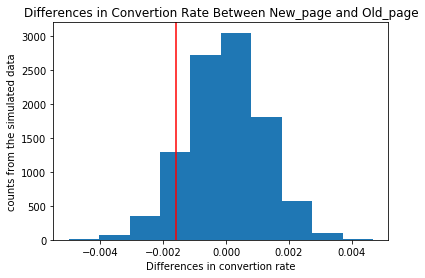

In [139]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='red') # the actual difference observed in the df2
plt.title('Differences in Convertion Rate Between New_page and Old_page')
plt.xlabel('Differences in convertion rate')
plt.ylabel('counts from the simulated data')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [140]:
# proportion of the p_diffs are greater than the obs_diff
(p_diffs>obs_diff).mean()

0.90290000000000004

From the above results, I can find that the p-value is 0.9028.  

If you see the histogram above, it seems that there are plenty of data from the red line to the right (alternative hypothesis), and if we calculate the p-value which is the mean of `p_diffs` data having greater value than the `obs_diff`, it is 0.903, which is greater than the `Type I error rate` of 0.05. Thus we cannot reject the null hypothesis, which assume that there is no difference between the `treatment` group and the `control`group.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [141]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page"').converted.sum()

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page"').converted.sum()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"').user_id.nunique()

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"').user_id.nunique()

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

**m.** Now let's use `sm.stats.proportions_ztest()` to compute the test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

> Two-tailed : $H_1$ as $(p_{new} = p_{old})$. <br>
> Left-tailed : $H_1$ as $(p_{new} < p_{old})$. <br>
> Right-tailed : $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 


### About the two-sample z-test
Recall that I have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for my two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

First, I need to decide if the hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, I will reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.


>For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
>For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

First, import the statsmodels library.

In [142]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old], alternative="larger")
print(z_score, p_value)

-1.31092419842 0.905058312759


Z-score of **-1.3109** means that the observed difference (`obs_diff`) is 1.31 standard deviations below the mean. Normally, $Z_{\alpha}$ or $Z_{0.05}$ is **1.645** for one-tailed tests and for a right-tailed test like this case, we can reject null if  𝑍𝑠𝑐𝑜𝑟𝑒  >  𝑍𝛼 . So from the fact that the 𝑍𝑠𝑐𝑜𝑟𝑒 of **-1.31** is not greater than **1.645**, we can NOT reject the null hypothesis.

Also the p-value here (0.905) is very similar to the p-value computed earlier (0.903). So I can NOT reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

###  3.1 
In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, I should perform **logistic regression** in this case.    
We can use logistic regression when the predicted response variable (which is `converted` here) is limited to a probability between 0 and 1 (in this case _not converted_ and _converted_).

**b.** The goal is to use **statsmodels** library to fit the regression model we specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, I first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [143]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate the regression model on the two columns I created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [144]:
# instantiate and fit the regression model
logis_model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logis_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of the model below, and use it as necessary to answer the following questions.

In [145]:
# Use summary2() method
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-12-26 14:46 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**In Part II**
- **$H_0$** (null) : **$p_{old}$** is equal to **$p_{new}$**
- **$H_1$** (alternative) : **$p_{new}$** is greater than **$p_{old}$**   

So, it is **one-sided**.

**In Part III**.  
- **$H_0$** (null) : **$p_{old}$** is equal to **$p_{new}$**
- **$H_1$** (alternative) : **$p_{old}$** is NOT equal to **$p_{new}$**

So, it is **two-sided.**  

Also, the current p-value of **0.1899** is still greater than the _Type I Error Rate_ of **0.05.**


I refered to the [Reference](https://www.statology.org/null-hypothesis-of-logistic-regression/).   
It says,   

> _"The null hypothesis states that the coefficient(β1) is equal to zero. In other words, there is no statistically significant relationship between the predictor variable, x, and the response variable, y._   
> _The alternative hypothesis states that coefficient(β1) is not equal to zero. In other words, there is a statistically significant relationship between x and y."_

**f.** Now, let's consider other things that might influence whether or not an individual converts.  I will discuss why it is a good idea to consider other factors to add into my regression model.  Are there any disadvantages to adding additional terms into my regression model?

Since there seems no relationship between `converted` and the `group`, we need to consider if there is other things that affects the dependent variable, `converted` along with the `group` variable.   

If their combined effect on the dependent variable, "converted", is ignored then the results that we get can be biased (technically known as omitted variable bias).

However, including too many variables in the model can lead to a problem called Multicollinearity.   
The more variables included in the model, typically, the less independent variation there will be for each of the individual variables. 

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. I will need to read in the **countries.csv** dataset and merge together the `df2` datasets on the appropriate rows. We call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


In [146]:
# Read the countries.csv
df_coun = pd.read_csv('countries.csv')
df_coun.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [147]:
# Join with the df2 dataframe
df_merged = df2.join(df_coun.set_index('user_id'), on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [148]:
# Create the necessary dummy variables
df_merged = df_merged.join(pd.get_dummies(df_merged['country']))
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


**h. Fit the model and obtain the results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there are significant effects on conversion.  

First, I will create the necessary additional columns, and fit the new model.

In [149]:
# Fit the model, and summarize the results
country_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'US', 'UK']])
country_result = country_model.fit()
country_result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-12-26 14:46 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

In [150]:
# Exponentiate the coefficents from the summary 
np.exp(country_result.params)

intercept    0.131332
ab_page      0.985168
US           1.041599
UK           1.051944
dtype: float64

Looking at all p-values in the summary, all the p-values are **greater** than the _Type I Error rate_ of 0.05.**   
So I can conclude that this logistic model is **NOT statistically significant** and there is no interaction between page and country.   
Therefore I **failed to reject the null hypothesis.** 

With coefficient values above, I can add

- For every unit for UK user, conversion is 1% more likely to happen compared to CA user, holding all other variables constant.    
- For every unit for US user, conversion is 1% more likely to happen compared to CA user, holding all other variables constant.     

But these findings are not practically significant as well.

**So my conclusion is that the new page is NOT better than the old page, which allows me to accept the null hypothesis.**  


In [ ]:
# convert the notebook to the .html file. 
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])